# Convergence stage 
## step 2: Data-efficient active learning (DEAL)

Active learning cycle based on OPES metad simulations and DEAL (data-efficient active learning) scheme. See the notebook 'lammps-opes.ipynb' for the first part.

Requirements:
* FLARE

In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt

from ase import Atom
from ase.io import read,write

sys.path.append("../../")
from mlputils.deal import filter_by_uncertainty,filter_by_cv,sort_traj,create_deal_input
from mlputils.utils import average_along_cv,compute_histogram
from mlputils.palette import paletteFessa

### a) Pre-selection via query-by-committee

#### Evaluate MACE uncertainty

Run `configs/mace/mace_uncertainty.py` to postprocess the trajectory generated by lammps, calculating the MACE uncertainty on the forces as the standard deviation of the predictions of an ensemble. 

In [3]:
folder = 'N-N/'

traj = read(f'{folder}/traj-std-ev10.xyz',index=':')
len(traj)

3001

#### Analyze uncertainty

Uncertainty distribution

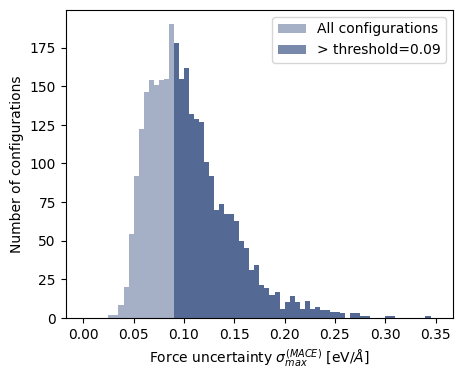

In [4]:
# define uncertainty of the configs as the max uncertainty on force components
def calculate_uncertainty(traj):
    return np.asarray([atoms.get_array('force_std_comp_max').max() for atoms in traj])

unc = calculate_uncertainty(traj)
bins_unc = np.linspace(0, 0.35, 71)

threshold = 0.09

x,(h1,h2) = compute_histogram(unc,bins_unc,threshold=threshold)
fig, ax = plt.subplots(figsize=(5,4),dpi=100)
ax.bar(x,h1,width=(x[1]-x[0]),color='fessa0',alpha=0.4,label='All configurations')
ax.bar(x,h2,width=(x[1]-x[0]),color='fessa0',alpha=0.6,label=f'> threshold={threshold}')
ax.set_xlabel(r'Force uncertainty $\sigma^{(MACE)}_{max}$ [eV/$\AA$]')
ax.set_ylabel('Number of configurations')
ax.legend(frameon=True)
plt.show()

CV distribution

In [5]:
# Function to calculate CV (N-N distance)
# will be used also later

def calculate_cv(traj):
    dist = lambda atoms: atoms[atoms.get_atomic_numbers()==7].get_distance(0,1,mic=True)

    if isinstance(traj[0],Atom):
        traj = [traj]
        
    return np.asarray( [dist(atoms) for atoms in traj])

# define bins for CV
cv = calculate_cv(traj)
bins_cv = np.linspace(1.2,3.2,11)

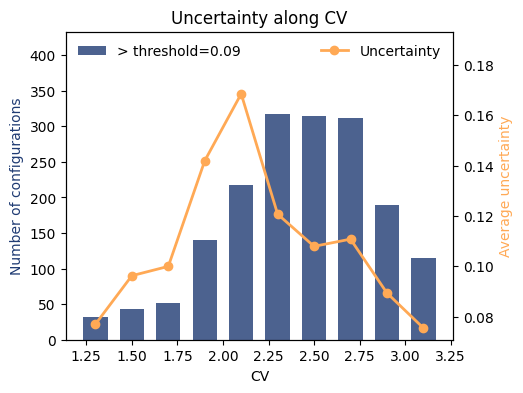

In [6]:
fig, axr = plt.subplots(figsize=(5,4),dpi=100)

# plot number of configurations > threshold
x,h1 = compute_histogram(cv,bins_cv)
x,h2 = compute_histogram(cv[unc>threshold],bins_cv)
#axr.bar(x, h1, width=(x[1]-x[0])/1.5, color='fessa0',zorder=0,alpha=0.4,label='All configurations')
axr.bar(x, h2, width=(x[1]-x[0])/1.5, color='fessa0',zorder=1,alpha=0.8,label=f'> threshold={threshold}' )

axr.set_xlabel('CV')
axr.set_ylabel('Number of configurations',color='fessa0')
axr.set_ylim(0,axr.get_ylim()[1]+100)
leg = axr.legend(fancybox=True, framealpha=0.7,loc='upper left')
leg.get_frame().set_linewidth(0.0)

# plot average uncertainty along CV
ax = axr.twinx()
_, unc_cv = average_along_cv(unc,cv,bins_cv)
ax.plot(x, unc_cv, color='fessa5',marker='o',zorder=2,linewidth=2, label='Uncertainty')

ax.set_ylabel('Average uncertainty',color='fessa5')
ax.set_ylim(None,ax.get_ylim()[1]+0.02)
leg = ax.legend(fancybox=True, framealpha=0.7,loc='upper right')
leg.get_frame().set_linewidth(0.0)
ax.set_title('Uncertainty along CV')
plt.show()

#### Filtering and sorting 

We filter samples based on :
* the uncertainty (`unc>threshold` and `unc<max_threshold` to avoid unphysical configurations)
* the CV (binning the space and selecting at most `max_samples_per_bin`)

In [7]:
max_threshold = 0.3
max_samples_per_bin = 1000

print('Initial traj:',len(traj),'\n')

traj_filter = filter_by_uncertainty(traj,unc,threshold,max_threshold)
unc_filter = calculate_uncertainty(traj_filter)
cv_filter = calculate_cv(traj_filter)
print('--> Filter by uncertainty:',len(traj_filter),'\n')

traj_filter = filter_by_cv(traj_filter,cv_filter,bins_cv,max_samples_per_bin)
unc_filter = calculate_uncertainty(traj_filter) 
cv_filter = calculate_cv(traj_filter)   
print('\n--> Filter by CV:',len(traj_filter))

Initial traj: 3001 

--> Filter by uncertainty: 1748 

CV distribution
1.20 < cv < 1.40 : 32 --> 32
1.40 < cv < 1.60 : 43 --> 43
1.60 < cv < 1.80 : 52 --> 52
1.80 < cv < 2.00 : 140 --> 140
2.00 < cv < 2.20 : 215 --> 215
2.20 < cv < 2.40 : 317 --> 317
2.40 < cv < 2.60 : 314 --> 314
2.60 < cv < 2.80 : 312 --> 312
2.80 < cv < 3.00 : 190 --> 190
3.00 < cv < 3.20 : 115 --> 115

--> Filter by CV: 1730


b) Sort samples:

After the function `filter_by_cv`, the samples of the corresponding trajectory are ordered based on the CV bins. We can decide to sort them in different ways:

- `shuffle` : shuffle the trajectory
- `uncertainty` : order by uncertainty (from the largest)

(see below for a discussion on the sorting)

In [8]:
# shuffle trajectory
traj_sorted = sort_traj(traj_filter,mode='shuffle',seed=42)

### b) DEAL selection via GP uncertainty

Here we create the input file for FLARE to select the GP uncertainty. The default inputs are stored in `configs/deal/deal.yaml`.
While the selection can be made using an existing GP model, trained e.g. on the previous data, and performing the DFT calculations on-the-fly, here we describe the alternative route. 
That is, to perform the selection using a GP model trained from scratch. In this way, we will extract a non-redundant set of configurations from the ones pre-selected based on the uncertainty. In this way, the selection process is very fast and does not suffer from the kernel limitations of large training sets, and the DFT calculations can be performed in an embarassingly parallel way. 

#### Create input

In [3]:
folder = 'N-N/'

# set DEAL parameters
cutoff = 5.5
gp_threshold = 0.1

create_deal_input(traj_sorted,
                  folder=folder+f"/deal/",
                  config_path='../../configs/deal/deal.yaml',
                  cutoff=cutoff,
                  threshold=gp_threshold)

NameError: name 'traj_sorted' is not defined

#### Perform DEAL selection 

This requires FLARE to be installed

> flare-otf input-deal.yaml


#### Analyze DEAL selection

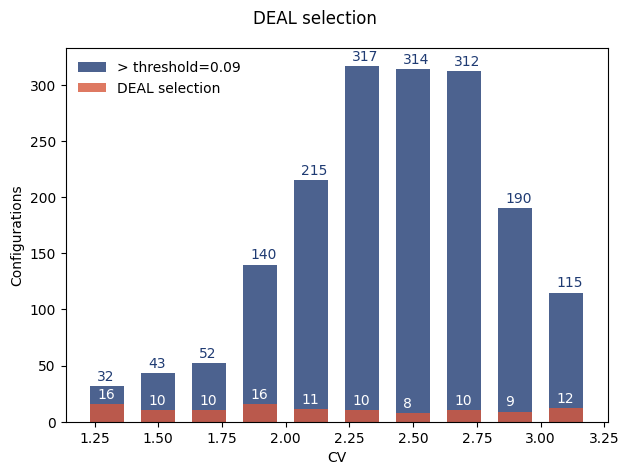

In [11]:
fig, ax = plt.subplots(dpi=100,sharex=True,sharey=True)

# plot number of configurations > threshold
x,h = compute_histogram(cv_filter,bins=bins_cv)
dx=x[1]-x[0]
ax.bar(x,h,width=dx/1.5,label=f'> threshold={threshold}',alpha=0.8,color='fessa0',zorder=0)
for xi,hi in zip(x,h):
    ax.text(xi-dx/5,hi+5,f'{hi}',color='fessa0')

# read traj
deal_folder = folder+f"/deal/"
traj = read(f'{deal_folder}/deal_dft.xyz',index=':')

cv = calculate_cv(traj)
x,h = compute_histogram(cv,bins=bins_cv)
dx=x[1]-x[0]
ax.bar(x,h,width=dx/1.5,label='DEAL selection',alpha=0.8,color='fessa6',zorder=1)
for xi,hi in zip(x,h):
    ax.text(xi-dx/5,hi+5,f'{hi}',color='w')

ax.set_xlabel('CV')
ax.set_ylabel('Configurations')
ax.legend(frameon=False)

plt.suptitle('DEAL selection')
plt.tight_layout()
plt.show()

### Supplementary


#### Comparison between sorting modes

The sorting step is especially important when using a GP model trained from scratch, since the first configurations will be selected more.\

First we plot the CV values and the uncertainty of the configurations in the different ordering schemes.

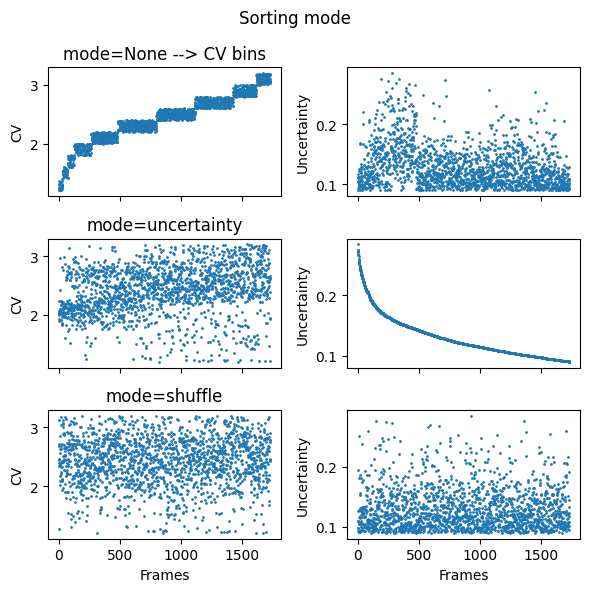

In [12]:
# make a subplots with 3 rows and 2 columns
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(6,6), dpi=100,sharex='col',sharey='col')

x = np.arange(len(traj_filter))
for i,mode in enumerate([None,'uncertainty','shuffle']):
    traj_sorted = sort_traj(traj_filter,mode=mode,seed=42,uncertainty=calculate_uncertainty(traj_filter))
    
    ax = axs[i,0]
    ax.scatter(x,calculate_cv(traj_sorted),s=1)
    ax.set_ylabel('CV')
    ax.set_title(f"mode={mode if mode is not None else 'None --> CV bins'}")
    
    ax = axs[i,1]
    ax.scatter(x,calculate_uncertainty(traj_sorted),s=1)
    ax.set_ylabel('Uncertainty')
    if i==2:
        axs[i,0].set_xlabel('Frames')
        axs[i,1].set_xlabel('Frames')
        
plt.suptitle('Sorting mode')
plt.tight_layout()

Generate input files and run FLARE:

> flare-otf run

In [12]:
cutoff = 5.5
gp_threshold = 0.08

sorting_modes = [None,'shuffle','uncertainty']

for mode in sorting_modes:

    traj_sorted = sort_traj(traj_filter,mode=mode,seed=42,uncertainty=calculate_uncertainty(traj_filter))

    deal_folder = folder+f"/deal/sort-modes-{threshold}/{mode}/"

    Path(deal_folder).mkdir(exist_ok=True,parents=True)

    create_deal_input(traj_sorted,
                  folder=deal_folder,
                  config_path='../../configs/deal/deal.yaml',
                  cutoff=cutoff,
                  threshold=gp_threshold)

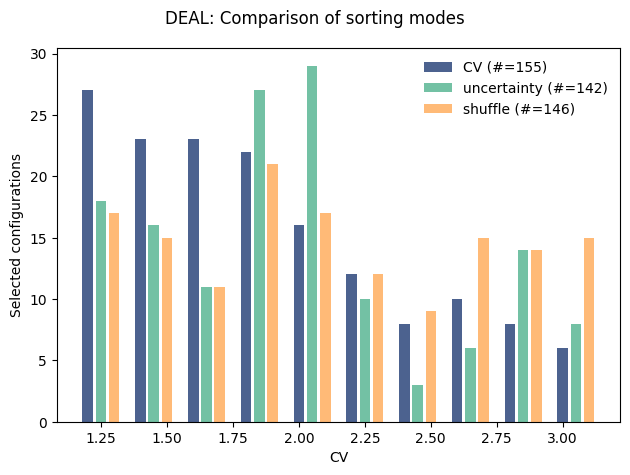

In [10]:
cutoff = 5.5
gp_threshold = 0.08

sorting_modes = [None,'uncertainty','shuffle']
colors = ['fessa0','fessa2','fessa5']
fig, ax = plt.subplots(dpi=100,sharex=True,sharey=True)

for i,mode in enumerate(sorting_modes):
    deal_folder = folder+f"/deal/sort-modes-{gp_threshold}/{mode}/"
    traj = read(f'{deal_folder}/deal_dft.xyz',index=':')

    cv = calculate_cv(traj)
    x,h = compute_histogram(cv,bins=bins_cv)
    dx=x[1]-x[0]
    ax.bar(x+i*dx/4-dx/2,h,width=dx/5,label=(mode if mode is not None else 'CV')+f' (#={len(traj)})',alpha=0.8,color=[colors[i]])

    if i==2:
        ax.set_xlabel('CV')
    if i==1:
        ax.set_ylabel('Selected configurations')
    ax.legend(frameon=False)

plt.suptitle('DEAL: Comparison of sorting modes')
plt.tight_layout()
plt.show()

Comparison with otf gp

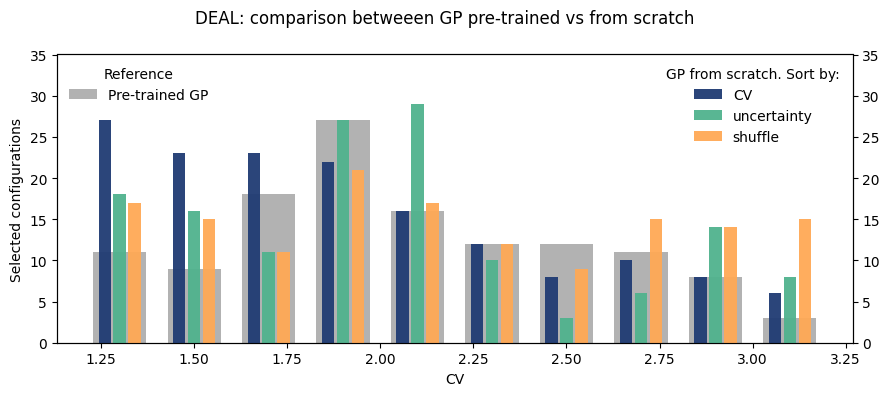

In [11]:
cutoff = 5.5
gp_threshold = 0.08

sorting_modes = [None,'uncertainty','shuffle']
colors = ['fessa0','fessa2','fessa5']
fig, ax2 = plt.subplots(dpi=100,figsize=(9,4),sharex=True,sharey=True)
xlim = [0,35]

# reference
traj = read('/leonardo_work/IscrB_AmmoFeCo/FeCo/flare/mace-2N-N2-small/database.xyz',index=':')
cv = calculate_cv(traj)
x,h = compute_histogram(cv,bins=bins_cv)
dx=x[1]-x[0]

ax2.bar(x,h,width=dx/1.4,label=f'Pre-trained GP',alpha=0.6,color='grey',zorder=-1)
ax2.legend(frameon=False,loc='upper left',title='Reference')
ax2.set_ylim(xlim[0],xlim[1])
ax = ax2.twinx()

for i,mode in enumerate(sorting_modes):
    deal_folder = folder+f"/deal/sort-modes-{gp_threshold}/{mode}/"
    traj = read(f'{deal_folder}/deal_dft.xyz',index=':')

    cv = calculate_cv(traj)
    x,h = compute_histogram(cv,bins=bins_cv)
    dx=x[1]-x[0]
    ax.bar(x+i*dx/5-dx/5,h,width=dx/6,label=mode if mode is not None else 'CV',alpha=0.95,color=[colors[i]])

ax2.set_xlabel('CV')
ax2.set_ylabel('Selected configurations')
ax.legend(frameon=False,title='GP from scratch. Sort by:',loc='upper right')
ax.set_ylim(xlim[0],xlim[1])


plt.suptitle('DEAL: comparison betweeen GP pre-trained vs from scratch')
plt.tight_layout()
plt.show()


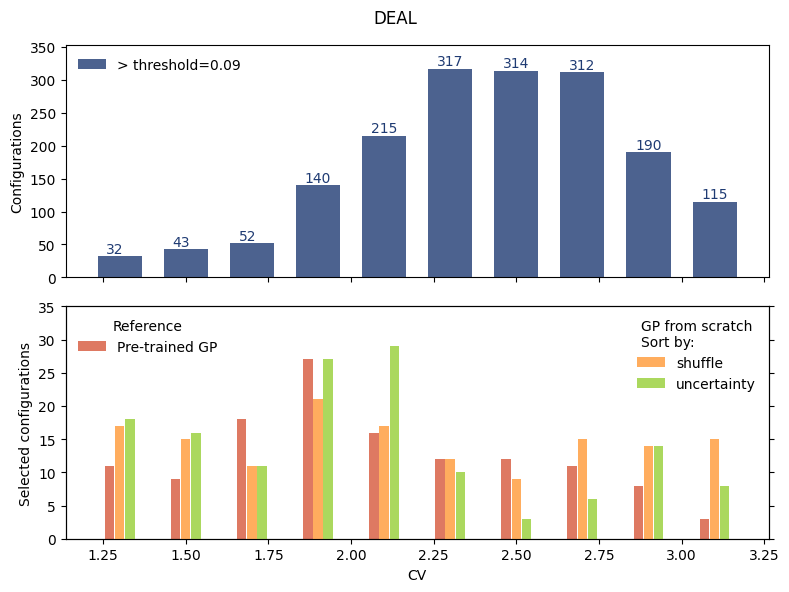

In [18]:
cutoff = 5.5
gp_threshold = 0.08

sorting_modes = ['shuffle','uncertainty']#,None]
colors = ['fessa5','fessa3','fessa1']
fig, axs = plt.subplots(2,1,dpi=100,figsize=(8,6),sharex=True)


ax = axs[0]

# plot number of configurations > threshold
x,h = compute_histogram(cv_filter,bins=bins_cv)
dx=x[1]-x[0]
ax.bar(x,h,width=dx/1.5,label=f'> threshold={threshold}',alpha=0.8,color='fessa0',zorder=0)
for xi,hi in zip(x,h):
    ax.text(xi-dx/5,hi+5,f'{hi}',color='fessa0')

# # read traj
# deal_folder = folder+f"/deal/"
# traj = read(f'{deal_folder}/deal_dft.xyz',index=':')

# cv = calculate_cv(traj)
# x,h = compute_histogram(cv,bins=bins_cv)
# dx=x[1]-x[0]
# ax.bar(x,h,width=dx/1.5,label='DEAL selection',alpha=0.8,color='fessa6',zorder=1)
# for xi,hi in zip(x,h):
#     ax.text(xi-dx/5,hi+5,f'{hi}',color='w')

ax.set_ylim(0,ax.get_ylim()[1]+20)
ax.set_ylabel('Configurations')
ax.legend(frameon=False)

ylim = [0,35]

ax2 = axs[1]

# reference
traj = read('/leonardo_work/IscrB_AmmoFeCo/FeCo/flare/mace-2N-N2-small/database.xyz',index=':')
cv = calculate_cv(traj)
x,h = compute_histogram(cv,bins=bins_cv)
dx=x[1]-x[0]

ax2.bar(x-dx/6.5,h,width=dx/7,label=f'Pre-trained GP',alpha=0.8,color='fessa6',zorder=-1)
ax2.legend(frameon=False,loc='upper left',title='Reference')
ax2.set_ylim(ylim[0],ylim[1])
ax = ax2.twinx()

for i,mode in enumerate(sorting_modes):
    deal_folder = folder+f"/deal/sort-modes-{gp_threshold}/{mode}/"
    traj = read(f'{deal_folder}/deal_dft.xyz',index=':')

    cv = calculate_cv(traj)
    x,h = compute_histogram(cv,bins=bins_cv)
    dx=x[1]-x[0]
    ax.bar(x+i*dx/6.5,h,width=dx/7,label=mode if mode is not None else 'CV',alpha=0.95,color=[colors[i]])

ax2.set_xlabel('CV')
ax2.set_ylabel('Selected configurations')
ax.legend(frameon=False,title='GP from scratch\nSort by:',loc='upper right')
ax.set_ylim(ylim[0],ylim[1])
ax.set_yticklabels([])

plt.suptitle('DEAL')
plt.tight_layout()
plt.show()


fessa5
fessa3


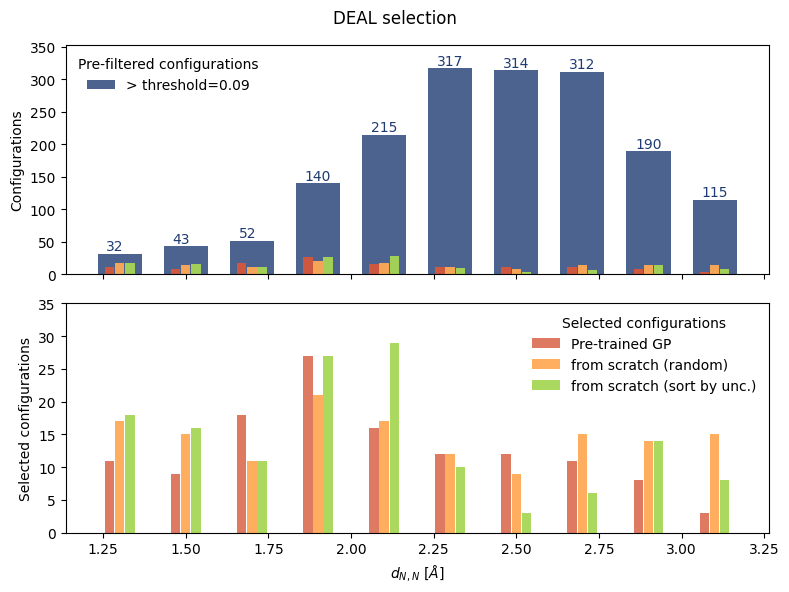

In [10]:
cutoff = 5.5
gp_threshold = 0.08

labels = ['from scratch (random)','from scratch (sort by unc.)']
sorting_modes = ['shuffle','uncertainty']#,None]
colors = ['fessa5','fessa3','fessa1']
fig, axs = plt.subplots(2,1,dpi=100,figsize=(8,6),sharex=True)


ax = axs[0]

# plot number of configurations > threshold
x,h = compute_histogram(cv_filter,bins=bins_cv)
dx=x[1]-x[0]
ax.bar(x,h,width=dx/1.5,label=f'> threshold={threshold}',alpha=0.8,color='fessa0',zorder=0)
for xi,hi in zip(x,h):
    ax.text(xi-dx/5,hi+5,f'{hi}',color='fessa0')

ax.set_ylim(0,ax.get_ylim()[1]+20)
ax.set_ylabel('Configurations')
ax.legend(frameon=False,title='Pre-filtered configurations')

ax = axs[0]

# reference
traj = read('/leonardo_work/IscrB_AmmoFeCo/FeCo/flare/mace-2N-N2-small/database.xyz',index=':')
cv = calculate_cv(traj)
x,h = compute_histogram(cv,bins=bins_cv)
dx=x[1]-x[0]
ax.bar(x-dx/6.5,h,width=dx/7,label=f'Pre-trained GP',alpha=0.95,color='fessa6',zorder=0)

for i,mode in enumerate(sorting_modes):
    deal_folder = folder+f"/deal/sort-modes-{gp_threshold}/{mode}/"
    traj = read(f'{deal_folder}/deal_dft.xyz',index=':')

    cv = calculate_cv(traj)
    x,h = compute_histogram(cv,bins=bins_cv)
    dx=x[1]-x[0]
    ax.bar(x+i*dx/6.5,h,width=dx/7,label=labels[i],alpha=0.95,color=colors[i])
    print(colors[i])

ax = axs[1]
ylim = [0,35]

# reference
traj = read('/leonardo_work/IscrB_AmmoFeCo/FeCo/flare/mace-2N-N2-small/database.xyz',index=':')
cv = calculate_cv(traj)
x,h = compute_histogram(cv,bins=bins_cv)
dx=x[1]-x[0]
ax.bar(x-dx/6.5,h,width=dx/7,label=f'Pre-trained GP',alpha=0.8,color='fessa6',zorder=0)

for i,mode in enumerate(sorting_modes):
    deal_folder = folder+f"/deal/sort-modes-{gp_threshold}/{mode}/"
    traj = read(f'{deal_folder}/deal_dft.xyz',index=':')

    cv = calculate_cv(traj)
    x,h = compute_histogram(cv,bins=bins_cv)
    dx=x[1]-x[0]
    ax.bar(x+i*dx/6.5,h,width=dx/7,label=labels[i],alpha=0.95,color=[colors[i]])

xlabel = r'$d_{N,N}$ [$\AA$]'
ax.set_xlabel(xlabel)
ax.set_ylabel('Selected configurations')
ax.legend(frameon=False,loc='upper right',title='Selected configurations')
ax.set_ylim(ylim[0],ylim[1])

plt.suptitle('DEAL selection')
plt.tight_layout()

fig.savefig('Figure_SI_deal_selection.png',dpi=200,bbox_inches='tight')
plt.show()


#### Comparison between thresholds

In [1]:
cutoff = 5.5
sort_mode = 'shuffle'
gp_thresholds = [0.06,0.07,0.08,0.09,0.1,0.11,0.12]

for gp_threshold in gp_thresholds:

    traj_sorted = sort_traj(traj_filter,mode=mode,seed=42,uncertainty=calculate_uncertainty(traj_filter))

    deal_folder = folder+f"/deal/threshold-{sort_mode}/{gp_threshold}/"

    Path(deal_folder).mkdir(exist_ok=True,parents=True)

    create_deal_input(traj_sorted,
                  folder=deal_folder,
                  config_path='../../configs/deal/deal.yaml',
                  cutoff=cutoff,
                  threshold=gp_threshold)

NameError: name 'sort_traj' is not defined

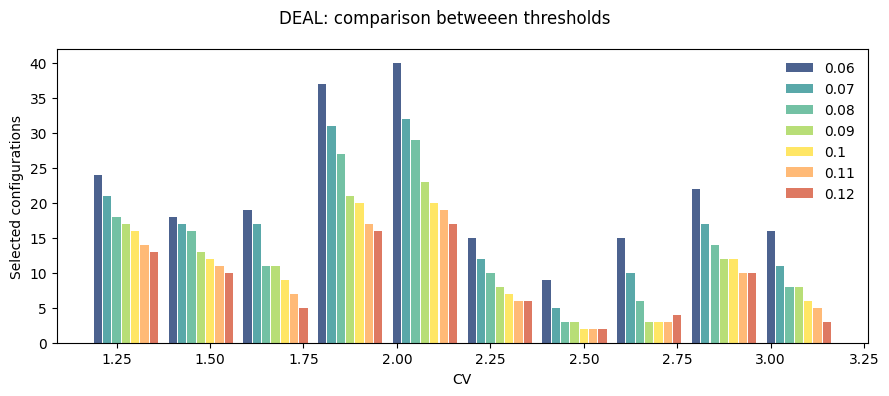

In [16]:
cutoff = 5.5
sort_mode = 'shuffle'
thresholds = [0.06,0.07,0.08,0.09,0.1,0.11,0.12]

fig, ax = plt.subplots(dpi=100,figsize=(9,4),sharex=True,sharey=True)

for i,gp_threshold in enumerate(gp_thresholds):
    deal_folder = folder+f"/deal/threshold-{sort_mode}/{gp_threshold}/"
    traj = read(f'{deal_folder}/deal_dft.xyz',index=':')

    cv = calculate_cv(traj)
    x,h = compute_histogram(cv,bins=bins_cv)
    dx=x[1]-x[0]
    ax.bar(x+i*dx/8-dx/2,h,width=dx/9,label=f'{threshold}',alpha=0.8,color=f'fessa{i}')

ax.set_xlabel('CV')
ax.set_ylabel('Selected configurations')
ax.legend(frameon=False)

plt.suptitle('DEAL: comparison betweeen thresholds')
plt.tight_layout()
plt.show()